<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!pip install gdown

### Continuity


> Samples are needed for sequence models and transformer models for input


😈 **Task 1:** How does a basic MLP differ from models like RNNs or ARIMA when used for time series forecasting?

😈 **Question 1:** What challenges might arise when feeding sequences into a feedforward model like an MLP?



Answer: A deep neural network would treat the time series as a sequence of independent samples, without memory of past states. We know it is able to model complex non-linear patterns due to its activation function & architecture, more specifically, even a 1-layer neural network (special case of deep neural network) can be trained toward estimating with arbitrary precision any continuous function, given enough hidden units & training time. However, the input is fixed (in this case, the window). A RNN maintains an internal state (memory) and processes sequences of variable length, thus naturally handling sequential data. However, it is more difficult to train and computationally more expensive. ARIMA is a statistical model based on the autoregressive, integrated moving average. It is very cheap to train, works well with stationary time series, but cannot handle complex, non-linear patterns well. It also has issue with long-term changes or dependencies within the time series.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

context_window = 336
prediction_horizon = 96
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp"]

In [13]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

## Download the .pkl files from drive

In [14]:
'''
import gdown

gdown.download(id="1XsCWRTpSZOBhZuL-a7OQ31PXa6ENvr1Q", output="X_test.pkl", quiet=True)
gdown.download(id="1OKQIVHf3d9TkdjJUaBu-PSe6FooJ6yhU", output="X_train.pkl", quiet=True)
gdown.download(id="1gs6gpCGocrob3il3gZgnKXFLm95r4Tyi", output="y_test.pkl", quiet=True)
gdown.download(id="1pW6wXMetnxr-eh0QhYr2O73b00jSVHaz", output="y_train.pkl", quiet=True)
'''

'\nimport gdown\n\ngdown.download(id="1XsCWRTpSZOBhZuL-a7OQ31PXa6ENvr1Q", output="X_test.pkl", quiet=True)\ngdown.download(id="1OKQIVHf3d9TkdjJUaBu-PSe6FooJ6yhU", output="X_train.pkl", quiet=True)\ngdown.download(id="1gs6gpCGocrob3il3gZgnKXFLm95r4Tyi", output="y_test.pkl", quiet=True)\ngdown.download(id="1pW6wXMetnxr-eh0QhYr2O73b00jSVHaz", output="y_train.pkl", quiet=True)\n'

In [15]:
from re import X
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("./X_train_corrected.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("./X_test_corrected.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("./y_train_corrected.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("./y_test_corrected.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

## Raw data csv is also made available for the select stations in URL:
#url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
localurl = "./timeseries_data/normalized_data_DOWNLOADED.csv"
dataframe = pd.read_csv(localurl,parse_dates=["datetime"])
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}

X_train = X_train_full[:,:,len(variable_column)].copy()
X_test = X_test_full[:,:,len(variable_column)].copy()
y_train = y_train_full[:,:,len(variable_column)].copy()
y_test = y_test_full[:,:,len(variable_column)].copy()

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(variable_column))
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(variable_column))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(variable_column))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(variable_column))

X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train_full shape: (427357, 336, 2), y_train_full shape: (427357, 96, 2)
X_test_full shape: (106841, 336, 2), y_test_full shape: (106841, 96, 2)
X_train shape: (427357, 336, 1), y_train shape: (427357, 96, 1)
X_test shape: (106841, 336, 1), y_test shape: (106841, 96, 1)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

Regarding task 4: Typically, other activation functions often work equally well compared to the very commonly used ReLU. But ReLU is easily implemented and derived and typically simpler to understand. It has been shown that ReLU's cutoff might not be optimal in some specific cases, but overall this comes with a tradeoff to simplicity.

Regarding task 5: Different optimizers have been proposed over time in the literature, but most use Adam for a reason, as it covers many cases where optimization may run into problems. For example, momentum is used to achieve a smoother optimization path and more training stability, and SGD is not using momentum by itself.

Regarding question 2: I previously mentioned ReLU's cutoff might not be optimal, and indeed, futher iterations examine that in some cases, a 'smoother' ReLU can increase training stability, and this can be what we want for time series data, due to autocorrelation for example we would like to have more smooth transitions, which would be more "correct" to the true data in a sense.

In [16]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

### Load the checkpoint

In [17]:
'''
!mkdir -p checkpoint

!gdown --folder https://drive.google.com/drive/folders/1-fkX0xKVcVOTJjBEz6pjl2D19vhjn8rs -O checkpoint
'''

'\n!mkdir -p checkpoint\n\n!gdown --folder https://drive.google.com/drive/folders/1-fkX0xKVcVOTJjBEz6pjl2D19vhjn8rs -O checkpoint\n'

In [18]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/1-fkX0xKVcVOTJjBEz6pjl2D19vhjn8rs?usp=drive_link
# and the path needs to be updated to checkpoint_dir below to local downloaded path:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

num_variables = 1 #len(variable_column)
mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
    print(f"\nTraining model for variable {var_idx + 1}/{num_variables}")

    X_train_single = X_train[:, :, var_idx]  # Shape: (samples, context_window)
    y_train_single = y_train[:, :, var_idx]  # Shape: (samples, pred_horizon)
    X_test_single = X_test[:, :, var_idx]    # Shape: (samples, context_window)

    y_train_single = y_train_single.reshape(y_train_single.shape[0], -1)

    # Model checkpointing
    checkpoint_path = os.path.join(checkpoint_dir, f"mlp_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {var_idx + 1}")
        mlp_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {var_idx + 1}")

        # Build MLP model
        mlp_model = Sequential([
            Input(shape=(X_train_single.shape[1],)),  # 24 timesteps (context window)
            Dense(mlp_hidden_units[0], activation=activation_fn)
        ])

        for units in mlp_hidden_units[1:]:
            mlp_model.add(Dense(units, activation=activation_fn))

        mlp_model.add(Dense(y_train_single.shape[1]))  # 6 timesteps (pred horizon)
        mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        # Train model
        training = mlp_model.fit(
            X_train_single, y_train_single,
            epochs=mlp_epochs, batch_size=mlp_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )
        training_histories[var_idx] = training.history

    y_pred_single = mlp_model.predict(X_test_single.astype(np.float32))
    mlp_predictions.append(y_pred_single)

mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test.shape[0], prediction_horizon, num_variables)  # Shape: (samples, pred hor, 5)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], prediction_horizon, 1)



Training model for variable 1/1
Training new model for variable 1
Epoch 1/5
21368/21368 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.2421
Epoch 1: val_loss improved from inf to 0.19499, saving model to ./checkpoint/mlp_var0.h5


21368/21368 ━━━━━━━━━━━━━━━━━━━━ 10s 473us/step - loss: 0.2421 - val_loss: 0.1950
Epoch 2/5
21324/21368 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 0.2072
Epoch 2: val_loss improved from 0.19499 to 0.18689, saving model to ./checkpoint/mlp_var0.h5


21368/21368 ━━━━━━━━━━━━━━━━━━━━ 10s 471us/step - loss: 0.2072 - val_loss: 0.1869
Epoch 3/5
21292/21368 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 0.2023
Epoch 3: val_loss improved from 0.18689 to 0.18231, saving model to ./checkpoint/mlp_var0.h5


21368/21368 ━━━━━━━━━━━━━━━━━━━━ 10s 470us/step - loss: 0.2023 - val_loss: 0.1823
Epoch 4/5
21299/21368 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 0.2008
Epoch 4: val_loss did not improve from 0.18231
21368/21368 ━━━━━━━━━━━━━━━━━━━━ 10s 471us/step - loss: 0.2008 - val_loss: 0.1873
Epoch 5/5
21346/21368 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.1990
Epoch 5: val_loss did not improve from 0.18231
21368/21368 ━━━━━━━━━━━━━━━━━━━━ 10s 477us/step - loss: 0.1990 - val_loss: 0.1906
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step


In [19]:
# Evaluate
y_test_reshaped = y_test.reshape(y_test.shape[0], prediction_horizon, num_variables) ## depending on
y_test = y_test_reshaped[:, :, var_idx]
y_pred = mlp_predictions[:, :, var_idx]

# Evaluate the model for this variable
evaluate_model(y_test, y_pred)

RMSE: 0.4662


0.4661568279852228

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


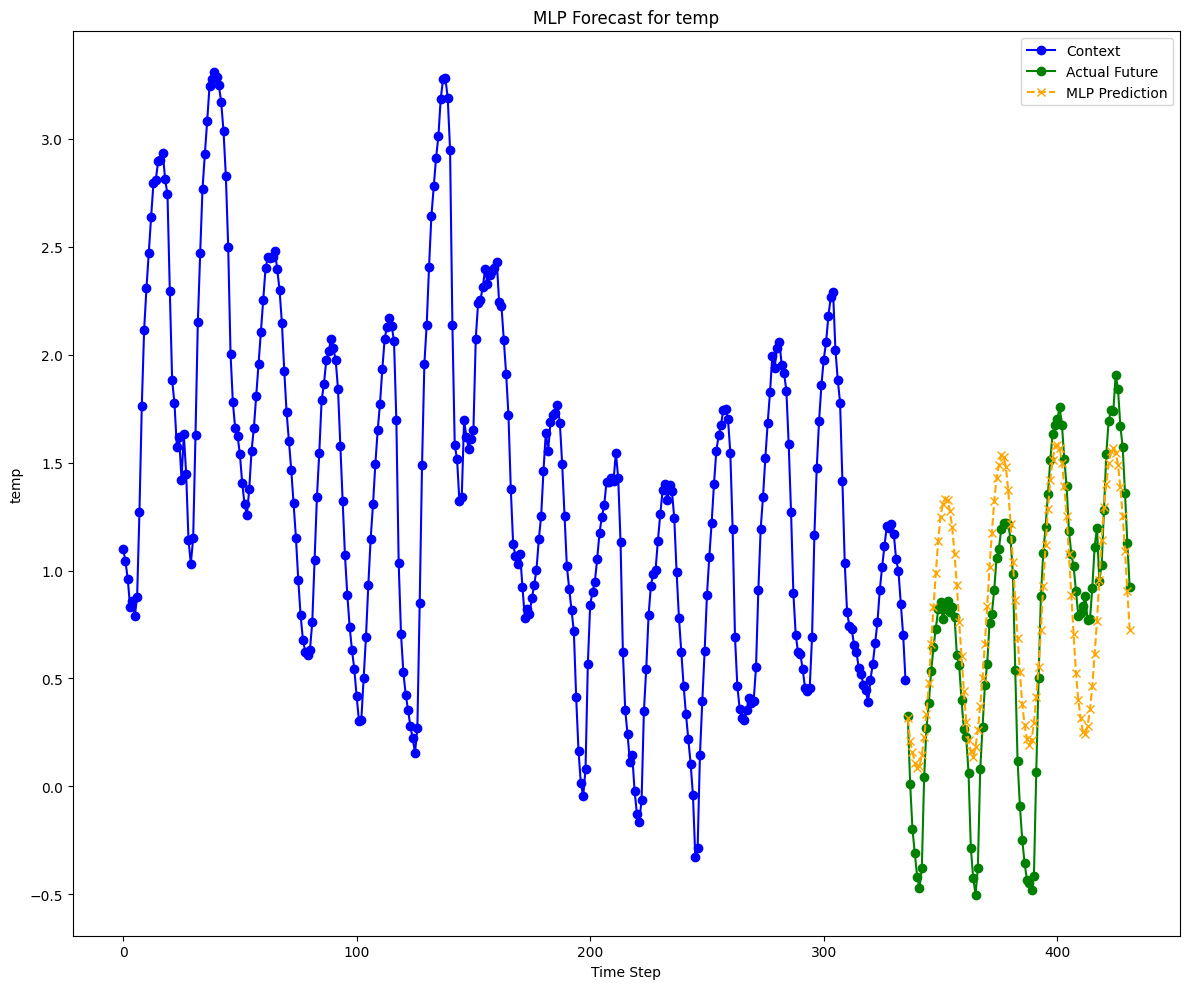

In [20]:
plt.figure(figsize=(12, 10))

for variable_idx in range(num_variables):
    mlp_model = load_model(
        os.path.join(checkpoint_dir, f"mlp_var{variable_idx}.h5"),
        custom_objects={"mse": MeanSquaredError()}
    )

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    X_test_sample=X_test_full[X_first_idx, :, variable_idx+1] # First column is station code hence adding 1
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    y_test_sample=y_test_full[y_first_idx, :, variable_idx+1] # First column is station code hence adding 1

    # Predict
    mlp_pred_sample = mlp_model.predict(X_test_sample.reshape(1, -1).astype(np.float32)).flatten()

    # Inverse scale
    context = X_test_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']
    actual_future = y_test_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']
    predicted_future = mlp_pred_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']

    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"MLP Forecast for {variable_column[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(variable_column[variable_idx])
    plt.legend()

plt.tight_layout()
plt.show()
